# Pan Fetal Immune - scVI data integration (updated scvi-tools)

In [1]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random
import scipy.sparse

Global seed set to 0


In [2]:
## import utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [3]:
scvi.__version__

'0.14.3'

## Load and prep data

In [4]:
data_dir = "/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/"
timestamp = "20210429"

### Load estimated gene dispersions for HVG selection

In [5]:
adata_lognorm_var = pd.read_csv(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.var.csv'.format(t=timestamp), index_col=0)

### Load count data

In [6]:
adata_raw = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.h5ad'.format(t=timestamp))
adata_raw.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Load obs with uniform labels

In [7]:
new_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv".format(t=timestamp), index_col=0)

/opt/conda/envs/ed6/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
adata_raw = adata_raw[new_obs.index]
adata_raw.obs = new_obs.copy()

In [9]:
adata_raw

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample'
    var: 'GeneID', 'GeneName'

In [10]:
import gc
gc.collect()

50981

Add dispersion estimates to `var`

In [12]:
adata_raw.var = adata_lognorm_var.copy()

## Param sweep for feature selection

1. Number of HVGS
2. Excluding or not excluding TCR/BCR genes
3. Number of latent dimensions

In [13]:
import torch
device = torch.device("cuda")

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    exclude_genes = []
    if remove_cc_genes:
        # adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)
        exclude_genes.extend(genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        exclude_genes.extend(genes.IG_genes)
        exclude_genes.extend(genes.TCR_genes)
        # adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        # adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
    
    adata = adata[:,~adata.var_names.isin(exclude_genes)]
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)

    ## Change gene names to ids
    adata.var_names = adata.var['GeneID'].values.copy()
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.model.SCVI.setup_anndata(adata, 
                                          categorical_covariate_keys = ["method", 'donor'], 
                                          copy=True)
    vae = scvi.model.SCVI(adata, n_latent=n_dims)
    vae.train(use_gpu=True, batch_size=256) ## increasing batch size as in retina atlas
    return(vae.get_latent_representation())
    
def save_scVI(adata, 
              timestamp,
              n_hvgs = 5000,
              remove_cc_genes = True,
                remove_tcr_bcr_genes = False,
                n_dims=20
             ):
    if remove_cc_genes:
        cc = "removeCC"
    else:
        cc = "keepCC"
    if remove_tcr_bcr_genes:
        tcr = "removeTCRBCR"
    else:
        tcr = "keepTCRBCR"
    outname = "PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.{h}HVGS.{cc}.{tcr}.{n}ldims.npy".format(t=timestamp, h=n_hvgs, cc=cc, tcr=tcr, n=n_dims)
    np.save(data_dir + outname, adata.obsm["X_scVI"])


In [17]:
nhvgs = [5000,7500,10000]
dims = [10,20,30]
remove = [{'remove_cc_genes':True, 'remove_tcr_bcr_genes':True}, {'remove_cc_genes':True, 'remove_tcr_bcr_genes':False}, {'remove_cc_genes':False, 'remove_tcr_bcr_genes':False}]

In [ ]:
for n in nhvgs:
    for r in remove:
        adata1 = prep_scVI(adata_raw, n_hvgs=n, remove_cc_genes=r["remove_cc_genes"], remove_tcr_bcr_genes=r["remove_tcr_bcr_genes"])
        for d in dims:
            
            adata1.obsm["X_scVI"] = train_scVI(adata1, n_dims=d)
            save_scVI(adata1, timestamp=timestamp, n_hvgs=n, remove_cc_genes=r["remove_cc_genes"], remove_tcr_bcr_genes=r["remove_tcr_bcr_genes"], n_dims=d)
        del adata1
        gc.collect()

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using batches from adata.obs["bbk"]                                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 911873 cells, 5000 vars, 33       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9/9: 100%|██████████| 9/9 [06:07<00:00, 40.83s/it, loss=807, v_num=1]


## Run scVI integration
We train using parameters optimized for online update with `scArches`, to be able to add query datasets in the future. Following the [scvi-tools vignette](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scarches_scvi_tools.html?highlight=encode_covariates#Train-reference).

In [14]:
adata = prep_scVI(adata_raw, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)

In [17]:
## Check feature selection
any(adata.var_names.isin(genes.cc_genes))

False

In [18]:
## Check
any(adata.var_names.isin(genes.TCR_genes))

False

In [19]:
adata = scvi.model.SCVI.setup_anndata(adata, 
                                      categorical_covariate_keys = ["method", 'donor'], 
                                      copy=True)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 911873 cells, 7499 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [20]:
arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae = scvi.model.SCVI(adata, n_latent=20, **arches_params)
vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [26:30<00:00,  3.98s/it, loss=1.13e+03, v_num=1]


### Check convergence

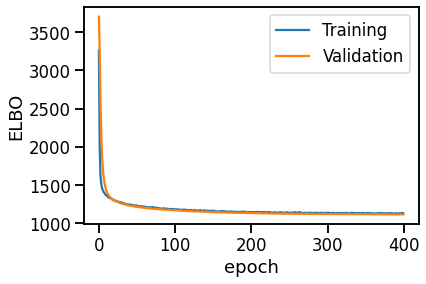

In [21]:
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");
plt.savefig("/home/jupyter/mount/gdrive/Pan_fetal/Updates_and_presentations/scvi_training_elbo.pdf", bbox_inches="tight")

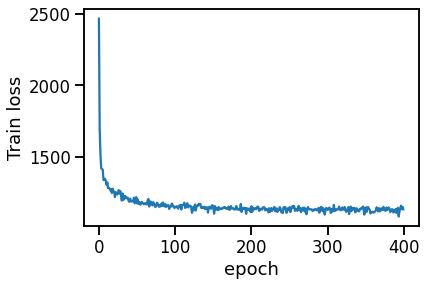

In [22]:
sns.set_context("talk")
plt.plot(vae.history["train_loss_step"], label="train");
# plt.plot(vae.history["reconstruction_loss_validation"], label="validation");
plt.xlabel("epoch");
plt.ylabel("Train loss");

In [23]:
## Save embedding
x_scvi = vae.get_latent_representation()
outname = "PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.V2.npy".format(t=timestamp)
np.save(data_dir + outname, x_scvi)

In [24]:
## Save training stats
model_history = vae.history.copy()
model_history.pop('train_loss_step')
pd.DataFrame.from_dict({k:v[k] for k,v in model_history.items()}).to_csv("PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.V2.train_history.csv".format(t=timestamp))

In [26]:
# save the reference model
model_dir = 'scvi_PFI_model_V2/'
if not os.path.exists(data_dir + model_dir):
    os.mkdir(data_dir + model_dir)
vae.save(data_dir + model_dir, overwrite=True)

---
---

## Explore output

In [5]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'

In [6]:
adata = sc.read_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.h5ad'.format(d=data_dir, t=timestamp))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
## Load obs
adata_obs = pd.read_csv('{d}PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv'.format(d=data_dir, t=timestamp),
                       index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
adata.obs = adata_obs.copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample'
    var: 'GeneID', 'GeneName'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

### Load results from scVI

In [10]:
def load_scvi_outs(adata, emb_file):
    X_scVI_emb = np.load(emb_file)
    X_scVI_umap = np.load(emb_file.rstrip(".npy") + ".UMAP.npy")
    X_scVI_clust = pd.read_csv(emb_file.rstrip(".npy") + ".clustering.csv", index_col=0)
    adata.obsm["X_scvi"] = X_scVI_emb
    adata.obsm["X_umap"] = X_scVI_umap
    adata.obs["scvi_clusters"] = X_scVI_clust.loc[adata.obs_names]["leiden_150"].astype("category")

In [11]:
load_scvi_outs(adata, "/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.V2.npy".format(t=timestamp))

... storing 'file' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical


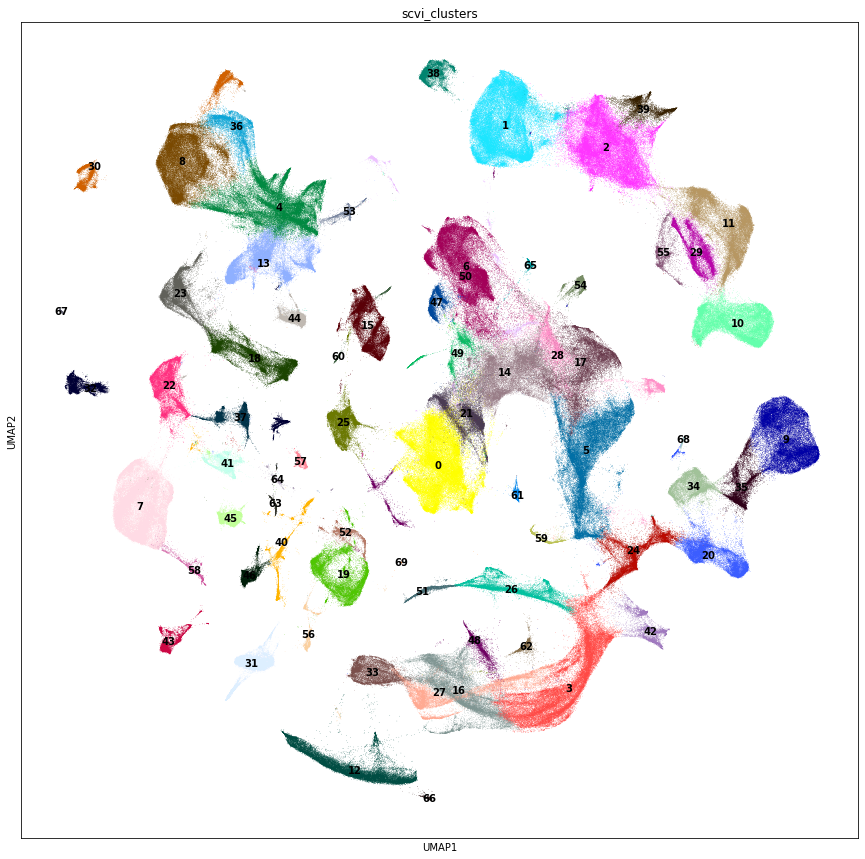

In [12]:
plt.rcParams["figure.figsize"] = [15,15]
sc.pl.umap(adata, color="scvi_clusters", legend_loc="on data", size=1)

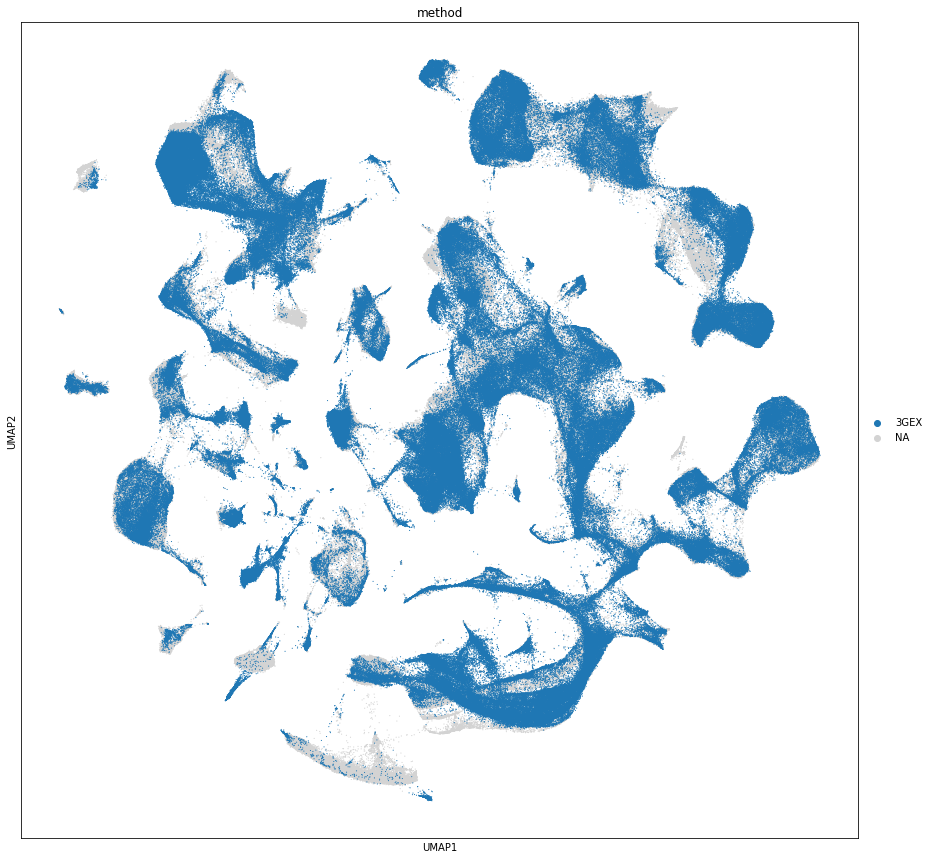

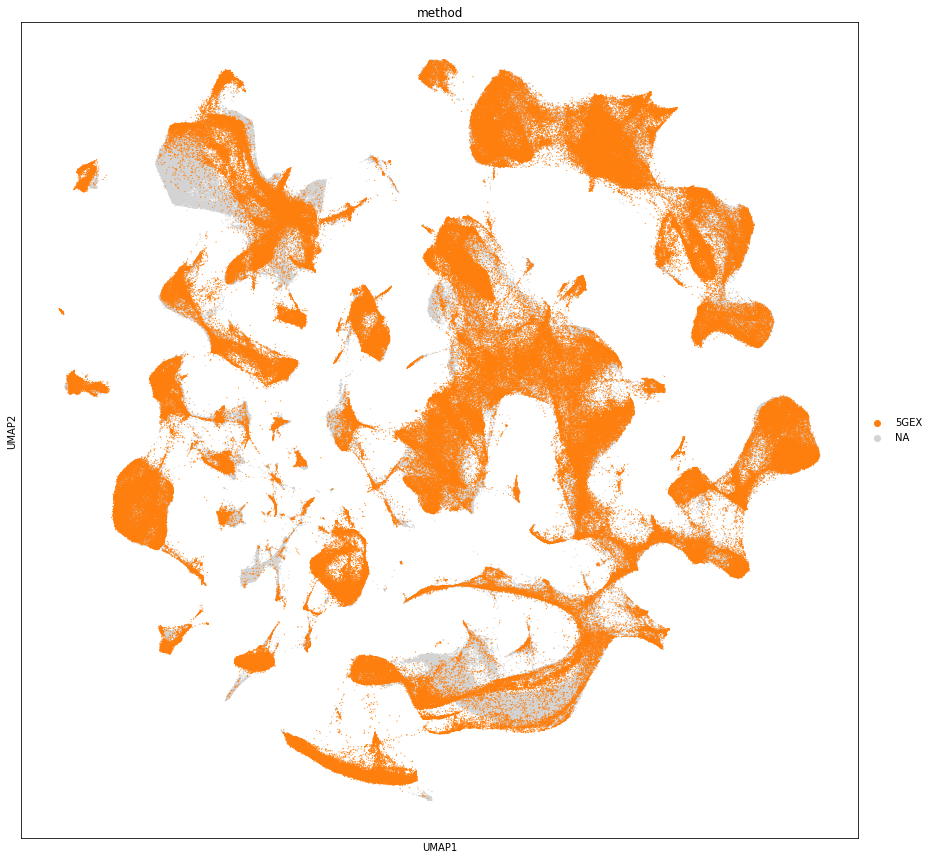

In [13]:
sc.pl.umap(adata, color=["method"], groups=["3GEX"], size=5)
sc.pl.umap(adata, color=["method"], groups=["5GEX"], size=5)

### Propagate existing labels to unannotated cells
Based on labels of k nearest neighbors

In [14]:
def _propagate_labels(adata, anno_col):
    anno_nans = ((adata.obs[anno_col]=="nan") | (adata.obs[anno_col].isna())).values
    nan2labelled_conns = adata.obsp["scvi_connectivities"][:,anno_nans]
    ## Get KNN edges between nans and all cells
    nan2labelled_conns[nan2labelled_conns.nonzero()] = 1
    
    ## Make dummy matrix of labels
    lab_dummies = pd.get_dummies(adata.obs[anno_col])
    lab_unique = lab_dummies.columns
    lab = lab_dummies.to_numpy().T
    
    ## Calculate label probability based on labels of neighbours
    class_prob =  lab @ nan2labelled_conns
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    
    ## Pick label with max prob
    new_labs = lab_unique[class_prob[:,lab_unique!="nan"].argmax(1)].to_numpy()
    max_prob = class_prob[:,lab_unique!="nan"].max(1)
    new_labs[max_prob==0] = np.nan # exclude cells with no neighbour != nan

    adata.obs[anno_col + "_propagated"] = adata.obs[anno_col]
    adata.obs[anno_col + "_propagated"].loc[anno_nans] = new_labs

In [15]:
## Calculate KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

In [16]:
obsp = adata.obsp.copy()

In [17]:
adata.obsp = obsp

In [18]:
adata

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'scvi_clusters'
    var: 'GeneID', 'GeneName'
    uns: 'leiden', 'scvi', 'umap', 'scvi_clusters_colors', 'method_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [19]:
adata.obs['uniform_label'] = adata.obs['uniform_label'].astype('str')
adata.obs['uniform_label_lvl0'] = adata.obs['uniform_label_lvl0'].astype('str')
adata.obs['uniform_label_expanded_merged'] = adata.obs['uniform_label_expanded_merged'].astype('str')

In [20]:
adata.obs.loc[adata.obs['uniform_label'].isna(), 'uniform_label'] = 'nan'
adata.obs.loc[adata.obs['uniform_label_lvl0'].isna(), 'uniform_label_lvl0'] = 'nan'
adata.obs.loc[adata.obs['uniform_label_expanded_merged'].isna(), 'uniform_label_expanded_merged'] = 'nan'

In [21]:
## Propagate labels
_propagate_labels(adata, anno_col="uniform_label")
_propagate_labels(adata, anno_col="uniform_label_lvl0")
_propagate_labels(adata, anno_col="uniform_label_expanded_merged")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Add putative cluster labels based on the most abundant annotations

In [22]:
adata.obs["leiden_150"] = adata.obs['scvi_clusters']

In [23]:
adata.obs['leiden_150'] = [str(x) for x in adata.obs['leiden_150']]

## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_lvl0_propagated', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_lvl0_propagated']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_lvl0_propagated'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

## Add predicted uniform label based on most frequent cell type
cl_counts = adata.obs.reset_index()[["uniform_label_expanded_merged_propagated", 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', "uniform_label_expanded_merged_propagated"]) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=["uniform_label_expanded_merged_propagated"])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label_expanded'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'uniform_label_propagated' as categorical
... storing 'uniform_label_lvl0_propagated' as categorical
... storing 'uniform_label_expanded_merged_propagated' as categorical
... storing 'leiden_150' as categorical
... storing 'leiden_150_pred_label' as categorical
... storing 'leiden_150_pred_label_expanded' as categorical


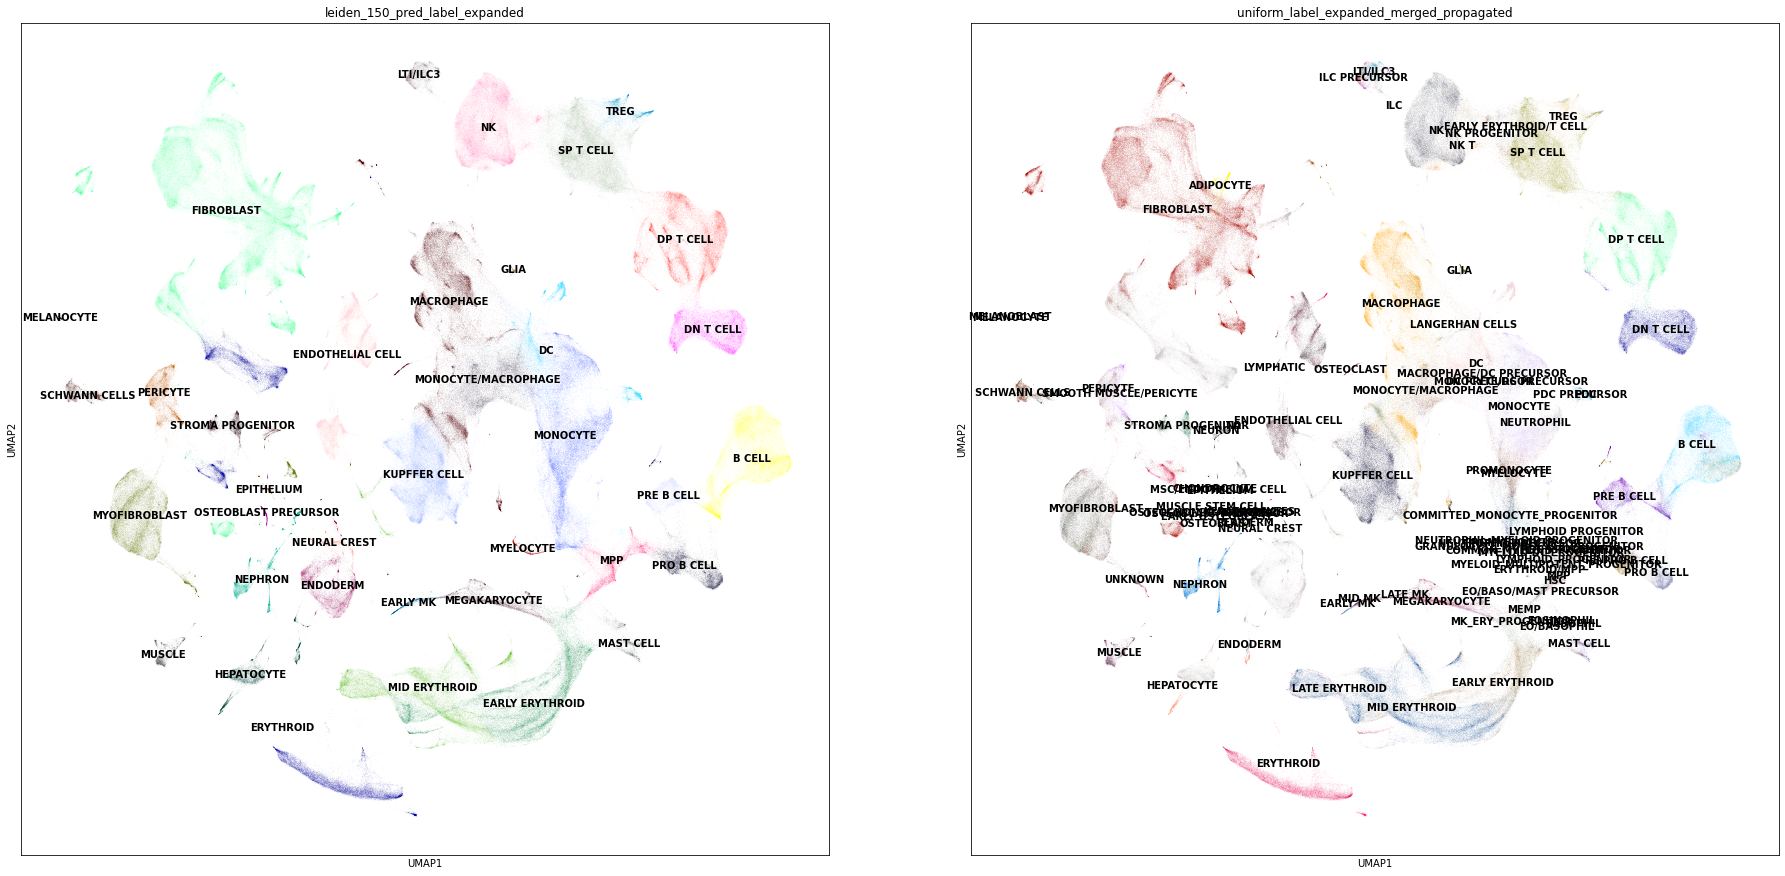

In [24]:
sc.pl.umap(adata, color=['leiden_150_pred_label_expanded',"uniform_label_expanded_merged_propagated"], legend_loc="on data")

### Putative doublet clusters

In [25]:
adata.var_names_make_unique()

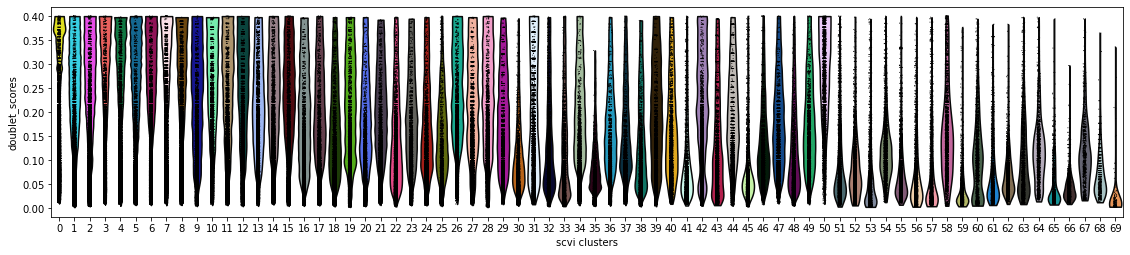

In [26]:
plt.rcParams["figure.figsize"] = [15,4]
sc.pl.violin(adata, "doublet_scores", groupby="scvi_clusters")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/matplotlib/axes/_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


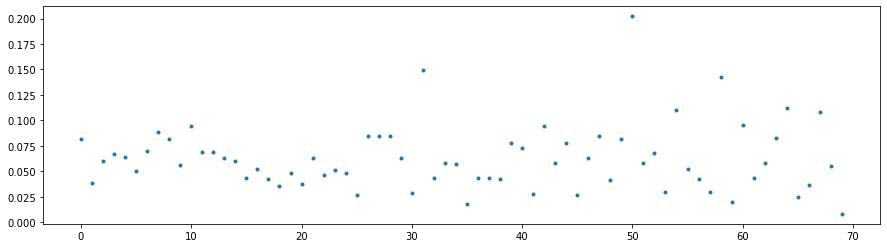

In [27]:
plt.rcParams["figure.figsize"] = [15,4]
plt.plot(adata.obs[["doublet_scores", "scvi_clusters"]].groupby('scvi_clusters').median(), '.')

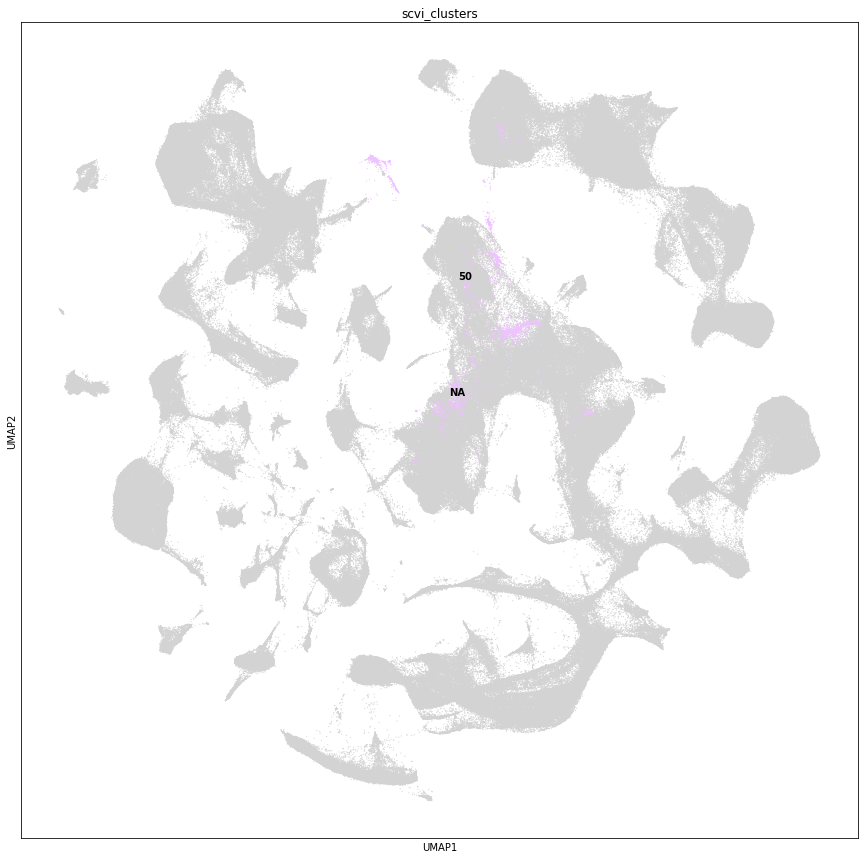

In [32]:
doub_clusters = np.where(adata.obs[["doublet_scores", "scvi_clusters"]].groupby('scvi_clusters').median() > 0.15)[0]
plt.rcParams["figure.figsize"] = [15,15]
sc.pl.umap(adata, color="scvi_clusters", groups=list(doub_clusters), legend_loc="on data", size=5)

### Visualize cluster purity

In [33]:
cl_counts = cl_counts.fillna(0).sort_values(cl_counts.columns[0])
cl_counts.columns = ["Cluster" + str(y) for x,y in cl_counts.columns]
cl_fracs = cl_counts/cl_counts.sum(0)

In [34]:
celltype_order = cl_counts.idxmax(0).sort_values().unique()
celltype_order = np.concatenate([celltype_order, cl_counts.index[~cl_counts.index.isin(celltype_order)].values])
cluster_order = cl_counts.idxmax(0).sort_values().index

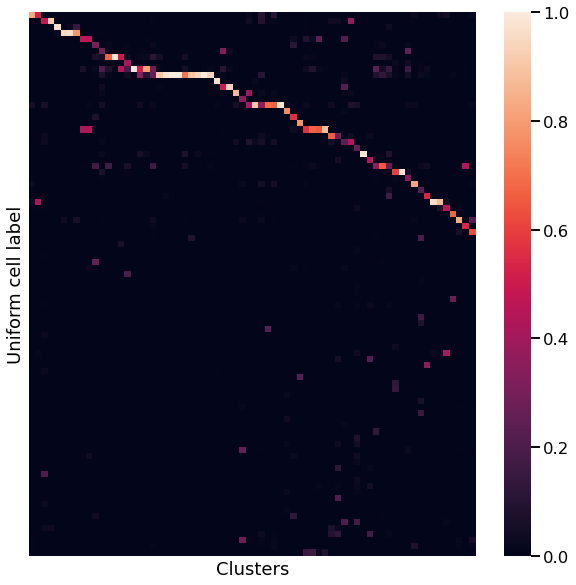

In [35]:
import matplotlib
sns.set_context("talk")
plt.rcParams["figure.figsize"] = [10,10]
sns.heatmap(cl_fracs.loc[celltype_order, cluster_order], xticklabels=False, yticklabels=False);
plt.xlabel("Clusters");
plt.ylabel("Uniform cell label");
plt.savefig("/home/jovyan/PFI_clustering.pdf", bbox_inches="tight")

## BBKNN vs scVI comparison figure

In [46]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [47]:
%load_ext rpy2.ipython


In [48]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [9]:
clusters_scvi = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/scVI_outs/PAN.A01.v01.entire_data_raw_count.20210429.scVI_out.clustering.csv', index_col=0)
clusters_bbknn = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/old_adatas/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.clustering.obs.csv', index_col=0)[['leiden_150']]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
anno_obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
clusters_bbknn = clusters_bbknn[clusters_bbknn.index.isin(anno_obs.index)]

In [12]:
anno_obs['clusters_bbknn'] = np.nan
anno_obs.loc[anno_obs.index[anno_obs.index.isin(clusters_bbknn.index)],'clusters_bbknn'] = clusters_bbknn.loc[anno_obs.index[anno_obs.index.isin(clusters_bbknn.index)], 'leiden_150']

In [13]:
anno_obs['clusters_scvi'] = np.nan
anno_obs.loc[anno_obs.index[anno_obs.index.isin(clusters_bbknn.index)],'clusters_scvi'] = clusters_scvi.loc[anno_obs.index[anno_obs.index.isin(clusters_scvi.index)], 'leiden_150']

In [159]:
comp_df = anno_obs[['uniform_label_expanded_merged', 'clusters_scvi', 'clusters_bbknn', 'uniform_label_lvl0', 'anno_lvl_2_final_clean']]
comp_df = comp_df.dropna()

In [160]:
figdir = '/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/BBKNN_vs_scVI/'

In [213]:
sns.set_context("paper")
def _plot_confusion_w_nmi(comp_df, col1, col2, 
                          xlab='scVI leiden clusters (res=1.5)',
                          ylab='Previous annotation',
                          figname='plot.pdf'):
    comp_df = comp_df.dropna()
    nmi = sklearn.metrics.adjusted_mutual_info_score(comp_df[col1], comp_df[col2])
    conf_mat = sc.metrics.confusion_matrix( col1,col2, comp_df).T
    col_order = conf_mat.idxmax(0).sort_values().index
    conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal

    sns.heatmap(conf_mat, xticklabels=False, yticklabels=True);
    plt.tight_layout();
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.title("NMI = {n}".format(n=np.round(nmi,2)))
    plt.savefig(figdir + figname);
    plt.show()

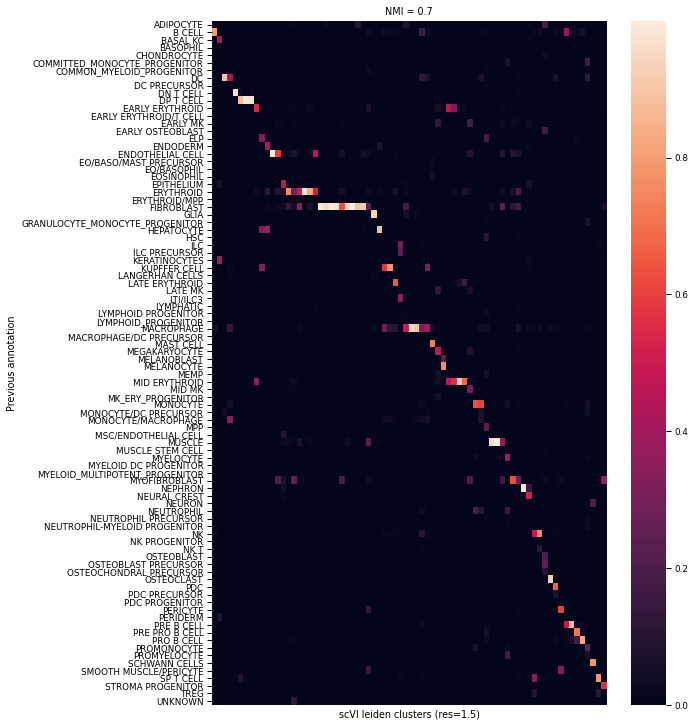

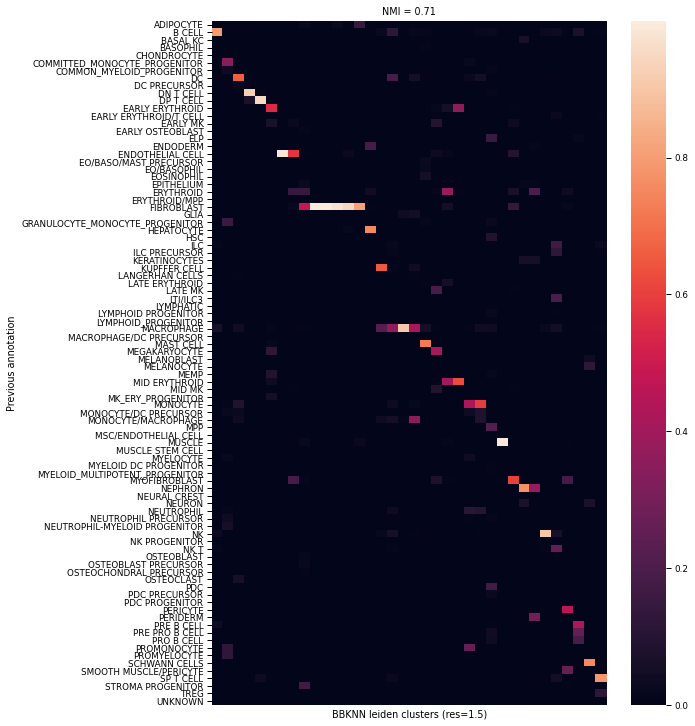

In [211]:
comp_df = anno_obs[['uniform_label_expanded_merged', 'clusters_scvi', 'clusters_bbknn', 'uniform_label_lvl0', 'anno_lvl_2_final_clean']]
_plot_confusion_w_nmi(comp_df, 'clusters_scvi','uniform_label_expanded_merged', 
                      ylab='Previous annotation', xlab='scVI leiden clusters (res=1.5)',
                      figname='oldAnno_vs_scVI_conf_mat.pdf')
_plot_confusion_w_nmi(comp_df, 'clusters_bbknn','uniform_label_expanded_merged', 
                      ylab='Previous annotation', xlab='BBKNN leiden clusters (res=1.5)',
                      figname='oldAnno_vs_BBKNN_conf_mat.pdf')

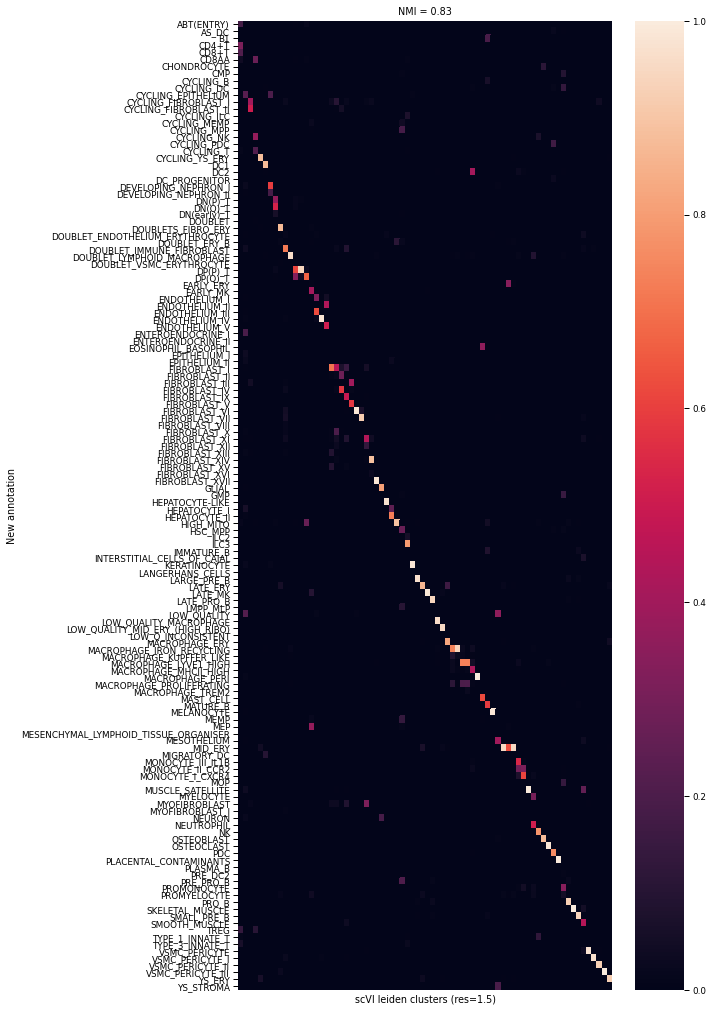

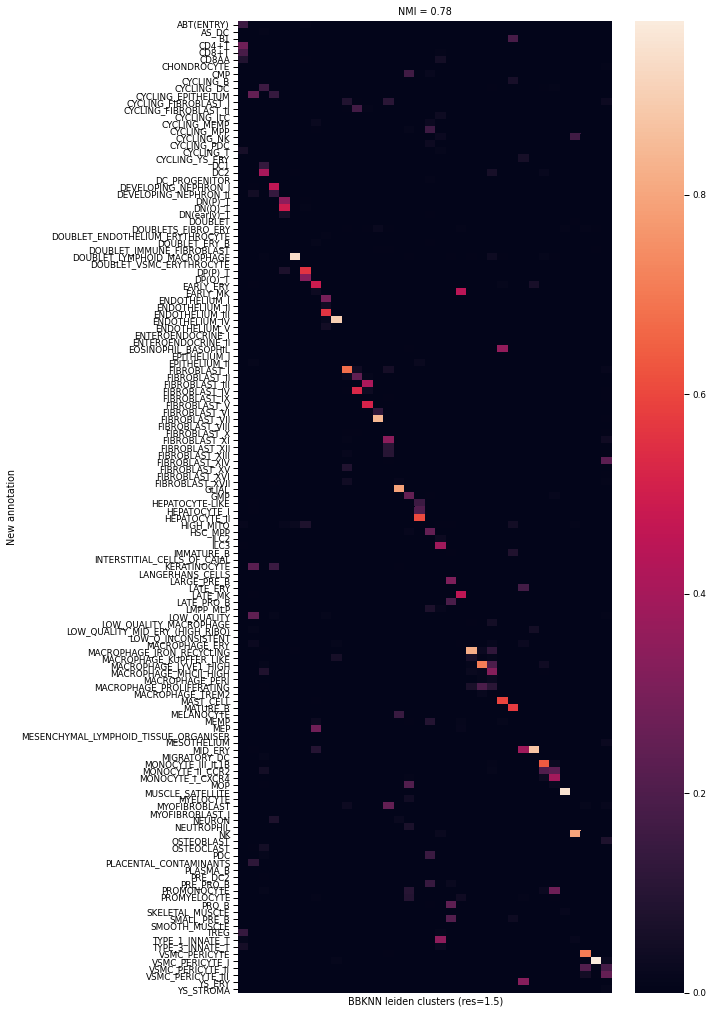

In [222]:
plt.rcParams['figure.figsize'] = [10, 14]
comp_df = anno_obs[['clusters_scvi', 'clusters_bbknn', 'anno_lvl_2_final_clean']]
_plot_confusion_w_nmi(comp_df, 'clusters_scvi','anno_lvl_2_final_clean', 
                      ylab='New annotation', xlab='scVI leiden clusters (res=1.5)',
                      figname='newAnno_vs_scVI_conf_mat.pdf')
_plot_confusion_w_nmi(comp_df, 'clusters_bbknn','anno_lvl_2_final_clean', 
                      ylab='New annotation', xlab='BBKNN leiden clusters (res=1.5)',
                      figname='newAnno_vs_BBKNN_conf_mat.pdf')

In [134]:
import sklearn
comp_df = anno_obs[['uniform_label_expanded_merged', 'clusters_scvi', 'clusters_bbknn', 'uniform_label_lvl0', 'anno_lvl_2_final_clean']]
comp_df = comp_df.dropna()

nmi_bbknn = []
nmi_scvi = []
for g in comp_df['uniform_label_lvl0'].unique():
    small_comp_df = comp_df[comp_df.uniform_label_lvl0 == g]
    nmi_bbknn.append(sklearn.metrics.adjusted_mutual_info_score( small_comp_df['uniform_label_expanded_merged'], small_comp_df['clusters_bbknn']))
    nmi_scvi.append(sklearn.metrics.adjusted_mutual_info_score( small_comp_df['uniform_label_expanded_merged'], small_comp_df['clusters_scvi']))

In [136]:
nmi_df = pd.DataFrame([nmi_bbknn, nmi_scvi]).T
nmi_df.columns=['NMI_BBKNN','NMI_scVI']
nmi_df['annotation_class'] = comp_df['uniform_label_lvl0'].unique()

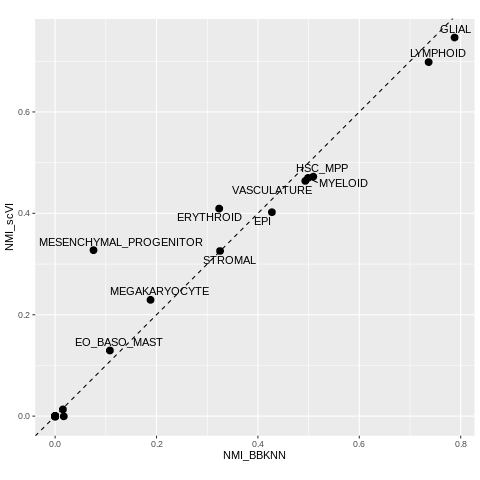

In [137]:
%%R -i nmi_df
nmi_df %>%
    ggplot(aes(NMI_BBKNN, NMI_scVI)) +
    geom_point(size=3) +
    geom_abline(linetype=2) +
    ggrepel::geom_text_repel(aes(label=annotation_class)) +
    coord_fixed() 
    

In [168]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

anno_groups_dict['NK/T CELLS'].extend(anno_groups_dict['ILC'])
del anno_groups_dict['ILC']
    
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

In [169]:
comp_df = anno_obs[['clusters_scvi', 'clusters_bbknn', 'anno_lvl_2_final_clean', 'donor', 'method']]
comp_df['batch'] = comp_df['method'] + "_" + comp_df['donor']
comp_df = comp_df.dropna()
comp_df['anno_group'] = [anno_groups_dict_rev[x] for x in comp_df['anno_lvl_2_final_clean']]

nmi_bbknn = []
nmi_scvi = []

# nmi_bbknn.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['anno_lvl_2_final_clean'], comp_df['clusters_bbknn']))
# nmi_scvi.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['anno_lvl_2_final_clean'], comp_df['clusters_scvi']))
# nmi_bbknn.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['batch'], comp_df['clusters_bbknn']))
# nmi_scvi.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['batch'], comp_df['clusters_scvi']))
for g in comp_df['anno_group'].unique():
    small_comp_df = comp_df[comp_df.anno_group == g]
    nmi_bbknn.append(sklearn.metrics.adjusted_mutual_info_score( small_comp_df['anno_lvl_2_final_clean'], small_comp_df['clusters_bbknn']))
    nmi_scvi.append(sklearn.metrics.adjusted_mutual_info_score( small_comp_df['anno_lvl_2_final_clean'], small_comp_df['clusters_scvi']))

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [170]:
nmi_df = pd.DataFrame([nmi_bbknn, nmi_scvi]).T
nmi_df.columns=['NMI_BBKNN','NMI_scVI']
nmi_df['annotation_class'] = comp_df['anno_group'].unique()
nmi_df

NMI_BBKNN  NMI_scVI annotation_class
0   0.673624  0.736648          MYELOID
1   0.539274  0.562555  ERYTHROID CELLS
2   0.495485  0.785109          B CELLS
3   0.554249  0.710487            OTHER
4   0.528731  0.548420      PROGENITORS
5   0.767847  0.843968           STROMA
6   0.666663  0.691059       NK/T CELLS

In [ ]:
%%R -i nmi_df
nmi_df %>%
    ggplot(aes(NMI_BBKNN, NMI_scVI)) +
    geom_point(size=3) +
    geom_abline(linetype=2) +
    ggrepel::geom_text_repel(aes(label=annotation_class)) +
    coord_fixed() +
    ylim(0,1) + xlim(0,1) +
    theme_bw(base_size=16) +
    title("Normalized Mutual Information\n(clusters in full dataset VS annotation)") +
    xlab()
    

In [152]:
comp_df = anno_obs[['clusters_scvi', 'clusters_bbknn', 'anno_lvl_2_final_clean', 'donor', 'method']]
comp_df['batch'] = comp_df['method'] + "_" + comp_df['donor']
comp_df = comp_df.dropna()
comp_df['anno_group'] = [anno_groups_dict_rev[x] for x in comp_df['anno_lvl_2_final_clean']]

In [155]:
nmi_bbknn = []
nmi_scvi = []

nmi_bbknn.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['anno_lvl_2_final_clean'], comp_df['clusters_bbknn']))
nmi_scvi.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['anno_lvl_2_final_clean'], comp_df['clusters_scvi']))
nmi_bbknn.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['method'], comp_df['clusters_bbknn']))
nmi_scvi.append(sklearn.metrics.adjusted_mutual_info_score( comp_df['method'], comp_df['clusters_scvi']))

In [146]:
adata_bbknn = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/old_adatas/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.h5ad')

In [179]:
adata_bbknn.obs['anno_lvl_2_final_clean'] = np.nan
adata_bbknn.obs.loc[obs_names, 'anno_lvl_2_final_clean'] = anno_obs.loc[obs_names, 'anno_lvl_2_final_clean'].values

In [182]:
adata_bbknn.obs['anno_lvl_2_final_clean'] = adata_bbknn.obs['anno_lvl_2_final_clean'].astype("str")
adata_bbknn.obs['anno_group'] = [anno_groups_dict_rev[x] if x!='nan' else np.nan for x in adata_bbknn.obs['anno_lvl_2_final_clean']]

In [176]:
del adata_bbknn.uns['anno_lvl_2_final_clean_colors']

saving figure to file ./figures/scvelo_BBKNN_embeddings.png


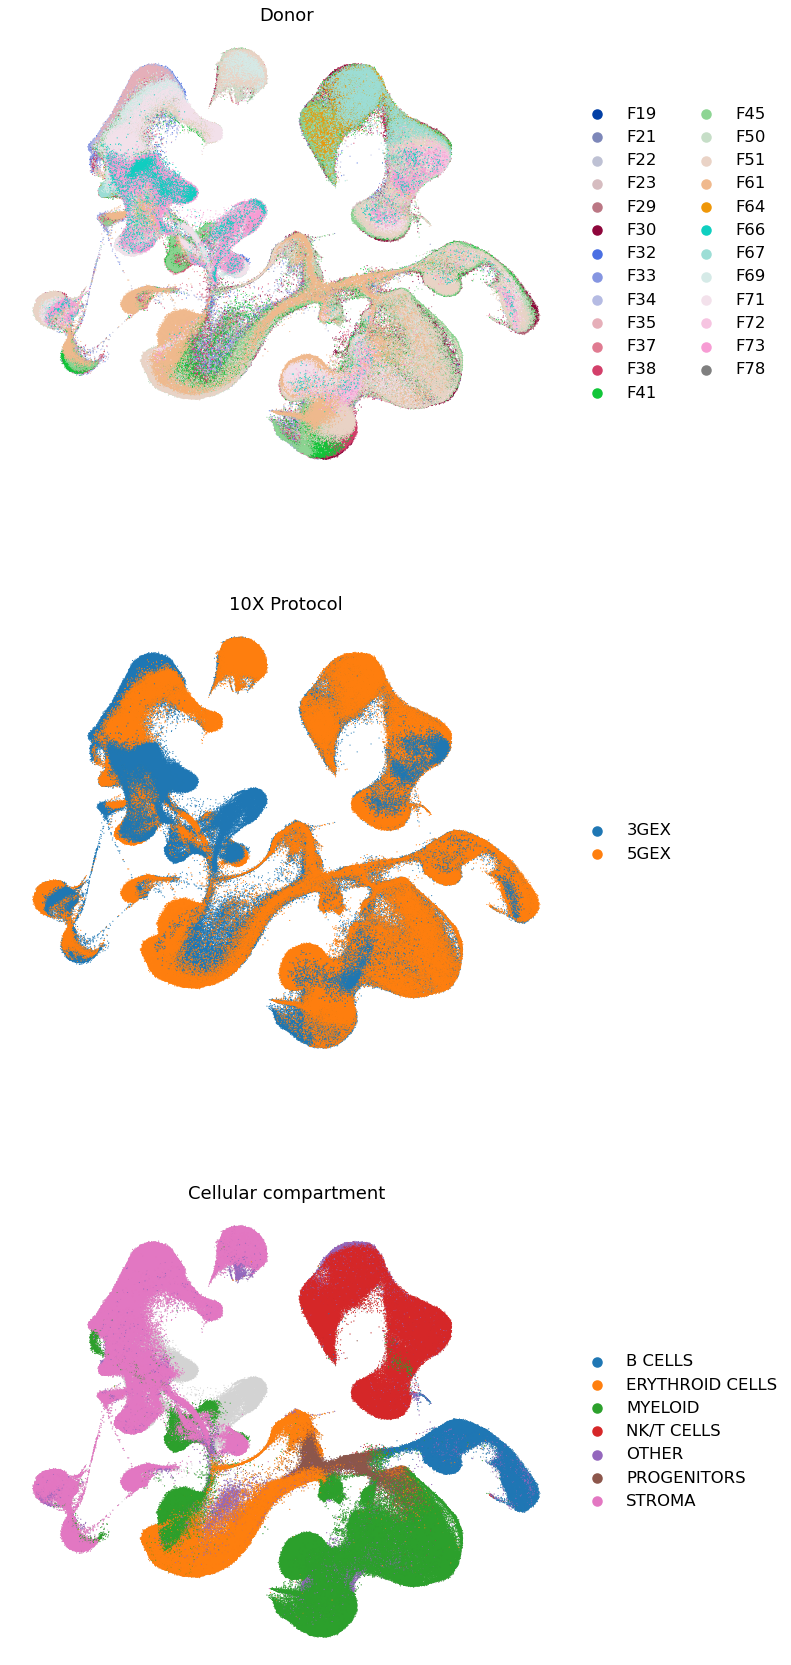

In [225]:
import scvelo as scv
sns.set_context('talk')
plt.rcParams['figure.figsize'] = [10, 10]
scv.pl.umap(adata_bbknn, color=['donor', 'method','anno_group'], size=5,
            title=['Donor', "10X Protocol","Cellular compartment"], frameon=False,
            wspace=0.5, ncols=1,
            legend_loc='right margin', save='BBKNN_embeddings.png')

## Define data subsets

By lineage

In [36]:
## Exclude maternal contaminants
mat_barcodes = pd.read_csv("../../metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
adata = adata[~adata.obs_names.isin(mat_barcodes)].copy()

In [37]:
## Exclude unusual sorts
adata = adata[~adata.obs['Sort_id'].isin(['CD137', 'MAIT'])]

In [38]:
## Exclude cells in putative doublet clusters
adata = adata[~adata.obs['leiden_150'].isin(doub_clusters)].copy()

In [39]:
adata

AnnData object with n_obs × n_vars = 902374 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'scvi_clusters', 'uniform_label_propagated', 'uniform_label_lvl0_propagated', 'uniform_label_expanded_merged_propagated', 'leiden_150', 'leiden_150_pred_label', 'leiden_150_pred_label_expanded'
    var: 'GeneID', 'GeneName'
    uns: 'leiden', 'scvi', 'umap', 'scvi_clusters_colors', 'method_colors', 'leiden_150_pred_label_expanded_colors', 'uniform_label_expanded_merged_propagated_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [40]:
splitting_labels = {}

anno_unif = adata.obs[["uniform_label_expanded_merged","uniform_label_lvl0"]].drop_duplicates()
hsc_immune_lvl0 = ["LYMPHOID", "MYELOID", "HSC_MPP", "MEGAKARYOCYTE", "ERYTHROID", "EO_BASO_MAST"]
splitting_labels["STROMA"] = anno_unif["uniform_label_expanded_merged"][~anno_unif["uniform_label_lvl0"].isin(hsc_immune_lvl0)].values
splitting_labels["HSC_IMMUNE"] = anno_unif["uniform_label_expanded_merged"][anno_unif["uniform_label_lvl0"].isin(hsc_immune_lvl0)].values

splitting_labels["LYMPHOID"] = anno_unif["uniform_label_expanded_merged"][anno_unif["uniform_label_lvl0"].isin(["LYMPHOID", "HSC_MPP"])].values.tolist()
splitting_labels["MYELOID"] = anno_unif["uniform_label_expanded_merged"][anno_unif["uniform_label_lvl0"].isin(["MYELOID", "HSC_MPP", "EO_BASO_MAST"])].values.tolist()
splitting_labels["MYELOID_LYMPHOID"] = splitting_labels["LYMPHOID"] + splitting_labels["MYELOID"]

## Exclude PDC clusters from single view
splitting_labels["LYMPHOID"] = [x for x in splitting_labels["LYMPHOID"] if 'PDC' not in x]
splitting_labels["MYELOID"] = [x for x in splitting_labels["MYELOID"] if 'PDC' not in x]

# splitting_labels["MEM_PROGENITORS"] = [x for x in splitting_labels["HSC_IMMUNE"] if x not in splitting_labels["MYELOID_LYMPHOID"]]
splitting_labels["MEM_PROGENITORS"] = anno_unif["uniform_label_expanded_merged"][anno_unif["uniform_label_lvl0"].isin(["ERYTHROID", "HSC_MPP", "MEGAKARYOCYTE"])].values.tolist()

In [41]:
splitting_labels

{'STROMA': ['nan', 'FIBROBLAST', 'SMOOTH MUSCLE/PERICYTE', 'PERICYTE', 'GLIA', ..., 'KERATINOCYTES', 'NEPHRON', 'STROMA PROGENITOR', 'LYMPHATIC', 'CHONDROCYTE']
 Length: 31
 Categories (91, object): ['ADIPOCYTE', 'B CELL', 'BASAL KC', 'BASOPHIL', ..., 'STROMA PROGENITOR', 'TREG', 'UNKNOWN', 'nan'],
 'HSC_IMMUNE': ['DC', 'MEMP', 'LTI/ILC3', 'MEGAKARYOCYTE', 'MONOCYTE', ..., 'NEUTROPHIL-MYELOID PROGENITOR', 'OSTEOCLAST', 'ERYTHROID/MPP', 'BASOPHIL', 'NK PROGENITOR']
 Length: 60
 Categories (91, object): ['ADIPOCYTE', 'B CELL', 'BASAL KC', 'BASOPHIL', ..., 'STROMA PROGENITOR', 'TREG', 'UNKNOWN', 'nan'],
 'LYMPHOID': ['MEMP',
  'LTI/ILC3',
  'SP T CELL',
  'B CELL',
  'TREG',
  'NK',
  'NK T',
  'HSC',
  'ILC',
  'LYMPHOID PROGENITOR',
  'GRANULOCYTE_MONOCYTE_PROGENITOR',
  'PRE PRO B CELL',
  'PRO B CELL',
  'MPP',
  'COMMITTED_MONOCYTE_PROGENITOR',
  'PRE B CELL',
  'ELP',
  'ILC PRECURSOR',
  'DP T CELL',
  'DN T CELL',
  'MK_ERY_PROGENITOR',
  'MYELOID DC PROGENITOR',
  'COMMON_MYELOID

In [42]:
for k in splitting_labels.keys():
    adata.obs["isin_" + k] = adata.obs["leiden_150_pred_label_expanded"].isin(splitting_labels[k])
    adata.obs["isin_" + k] = adata.obs["isin_" + k].astype("category")

In [43]:
split_cols = [x for x in adata.obs.columns if x.startswith("isin")]

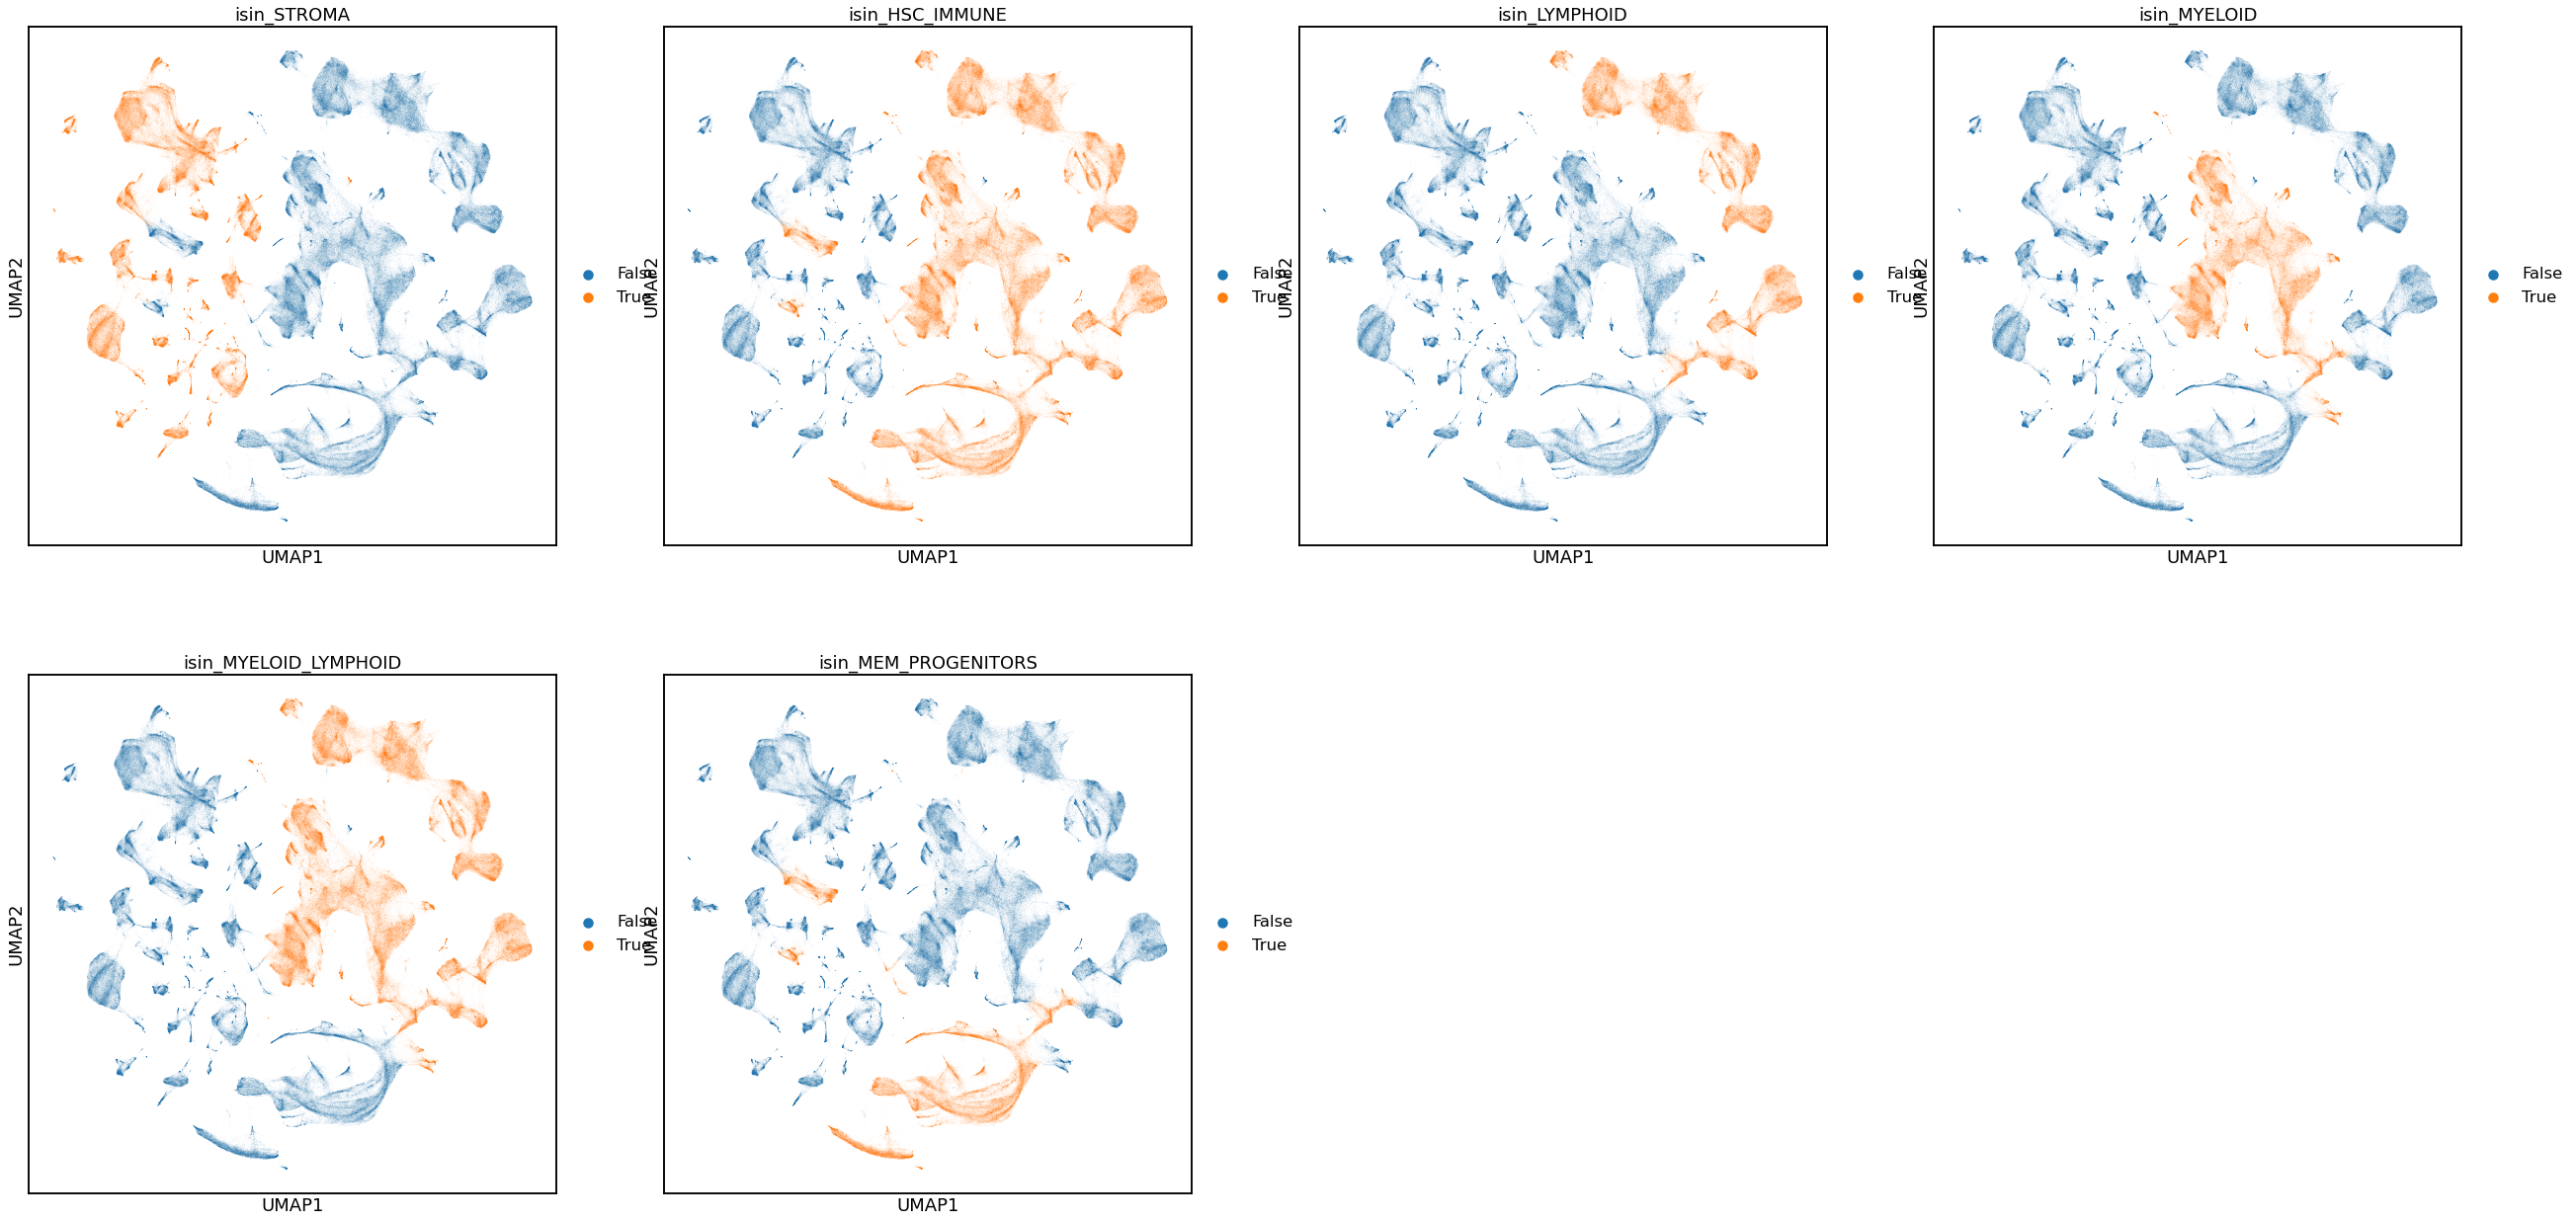

In [44]:
sc.pl.umap(adata, color=split_cols)

### Save adatas of splits (for scVI)

In [45]:
adata_raw = sc.read_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.h5ad'.format(d=data_dir, t=timestamp))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [46]:
adata_raw = adata_raw[adata.obs_names].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [47]:
splitting_labels.keys()

dict_keys(['STROMA', 'HSC_IMMUNE', 'LYMPHOID', 'MYELOID', 'MYELOID_LYMPHOID', 'MEM_PROGENITORS'])

In [48]:
adata.obs = adata.obs.drop(['predicted_doublets'], 1)

In [49]:
for s in [ 'LYMPHOID', 'MYELOID', 'MEM_PROGENITORS', 'STROMA']:
    sdata = adata[adata.obs["isin_" + s]==True]
    sdata.obs[split_cols] = sdata.obs[split_cols].astype('bool')
    sdata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.{s}_NEW.h5ad'.format(d=data_dir, t=timestamp, s=s))
    sdata_raw = adata_raw[adata.obs["isin_" + s]==True] 
    sdata_raw.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.{s}_NEW.h5ad'.format(d=data_dir, t=timestamp, s=s))

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [50]:
for s in ['HSC_IMMUNE','MYELOID_LYMPHOID']:
    sdata = adata[adata.obs["isin_" + s]==True]
    sdata.obs[split_cols] = sdata.obs[split_cols].astype('bool')
    sdata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.{s}_NEW.h5ad'.format(d=data_dir, t=timestamp, s=s))
    sdata_raw = adata_raw[adata.obs["isin_" + s]==True] 
    sdata_raw.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.{s}_NEW.h5ad'.format(d=data_dir, t=timestamp, s=s))

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
